In [1]:
# from signal_processors import *
# import torch.nn as nn
# import torch

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def mlp(in_size, hidden_size, n_layers):
#     channels = [in_size] + [hidden_size] * n_layers
#     net = []
#     for i in range(n_layers):
#         net.append(nn.Linear(channels[i], channels[i + 1]))
#         net.append(nn.LayerNorm(channels[i + 1]))
#         net.append(nn.LeakyReLU())
#     return nn.Sequential(*net)

# def gru(n_input, hidden_size):
#     return nn.GRU(n_input, hidden_size, batch_first=True)

# class textsynth_DDSP(nn.Module):
#     def __init__(self, hidden_size, N_filter_bank, deepness, compression, frame_size, sampling_rate):
#         super().__init__()

#         self.N_filter_bank = N_filter_bank
#         self.seed = seed_maker(frame_size, sampling_rate, N_filter_bank)
#         self.frame_size = frame_size
#         self.param_per_env = int(frame_size / (2*N_filter_bank*compression))
        
#         self.f_encoder = mlp(1, hidden_size, deepness)
#         self.l_encoder = mlp(N_filter_bank, hidden_size, deepness)
#         self.z_encoder = gru(2 * hidden_size, hidden_size)
    
#         self.a_decoder_1 = mlp(3 * hidden_size, hidden_size, deepness)
#         self.a_decoder_2 = nn.Linear(hidden_size, 16 * self.param_per_env)
#         self.p_decoder_1 = mlp(3 * hidden_size, hidden_size, deepness)
#         self.p_decoder_2 = nn.Linear(hidden_size, 16 * self.param_per_env)

#     def encoder(self, spectral_centroid, loudness):
#         f = self.f_encoder(spectral_centroid)
#         # print("f shape: ",f.shape)
#         l = self.l_encoder(loudness)
#         # print("l shape: ",l.shape)
#         z, _ = self.z_encoder(torch.cat([f,l], dim=-1).unsqueeze(0))
#         # print("z_1 shape: ",z.shape)
#         z = z.squeeze(0)
#         # print("z_2 shape: ",z.shape)
#         return torch.cat([f,l,z], dim=-1)

#     def decoder(self, latent_vector):
#         a = self.a_decoder_1(latent_vector)
#         a = self.a_decoder_2(a)
#         a = torch.sigmoid(a)
#         p = self.p_decoder_1(latent_vector)
#         p = self.p_decoder_2(p)
#         p = 2*torch.pi*torch.sigmoid(p)
#         real_param = a * torch.cos(p)
#         imag_param = a * torch.sin(p)
#         return real_param, imag_param

#     def forward(self, spectral_centroid, loudness):
#         # print("sp.centroid shape: ",spectral_centroid.shape)
#         # print("loudness.shape:    ",loudness.shape)
#         #encoder
#         latent_vector = self.encoder(spectral_centroid, loudness)
#         # print("latent_vector.shape: ",latent_vector.shape)
#         #decoder
#         real_param, imag_param = self.decoder(latent_vector)
#         # print("real_param.shape: ",real_param.shape)
#         # print("imag_param.shape: ",imag_param.shape)

#         signal = textsynth_env_batches(real_param, imag_param, self.seed, self.N_filter_bank, self.frame_size)
#         return signal, self.seed

# # Initialize model and move it to the appropriate device
# hidden_size = 128  # Example hidden size
# N_filter_bank = 16  # Example filter bank size
# frame_size = 2**15  # Example frame size
# sampling_rate = 44100  # Example sampling rate
# compression = 8  # Placeholder for compression

# model = textsynth_DDSP(hidden_size=128, N_filter_bank=16, deepness=2, compression=8, frame_size=2**15, sampling_rate=44100).to(device)

In [2]:
# # Generate dummy input data
# batch_size = 7 # Example batch size
# spectral_stats = torch.randn(batch_size, 1).to(device)  # Dummy spectral stats with shape (batch_size, 2)
# loudness_stats = torch.randn(batch_size, N_filter_bank).to(device)  # Dummy loudness stats with shape (batch_size, 2 * N_filter_bank)

# # Forward pass
# output_signal, seed = model(spectral_stats, loudness_stats)

# for i in range(7):
#     plotter(output_signal[i,:], 44100)

In [3]:
# from torch.utils.data import Dataset, DataLoader
# import numpy as np
# import librosa
# import torchaudio

# def feature_extractor(signal, sample_rate):
#     size = signal.shape[0]
#     sp_centroid = torchaudio.functional.spectral_centroid(signal, sample_rate, 0, torch.hamming_window(size), size, size, size) 

#     low_lim = 20  # Low limit of filter
#     high_lim = sample_rate / 2  # Centre freq. of highest filter

#      # Initialize filter bank
#     erb_bank = fb.EqualRectangularBandwidth(size, sample_rate, N_filter_bank, low_lim, high_lim)
    
#     # Generate subbands for noise
#     erb_bank.generate_subbands(signal)
    
#     # Extract subbands
#     erb_subbands_signal = erb_bank.subbands[:, 1:-1]

#     loudness = torch.norm(erb_subbands_signal, dim=0)
#     return [sp_centroid[0], loudness]

# class SoundDataset(Dataset):
#     def __init__(self, audio_path, frame_size, hop_size, sampling_rate):
#         self.audio_path = audio_path
#         self.frame_size = frame_size
#         self.hop_size   = hop_size
#         self.sampling_rate = sampling_rate
#         self.audio, _ = librosa.load(audio_path, sr=sampling_rate)
#         self.content = []

#     def compute_dataset(self):
#         audio_tensor = torch.tensor(self.audio)
#         size = audio_tensor.shape[0]
#         dataset_size = (size - self.frame_size) // self.hop_size
#         for i in range(dataset_size):
#             segment = audio_tensor[i * self.hop_size: i * self.hop_size + self.frame_size]
#             features = feature_extractor(segment, self.sampling_rate)
#             self.content.append([features, segment])
#         print(dataset_size)

# dataset = SoundDataset(audio_path='noises/fire_long.wav', frame_size=2**15, hop_size=2**10, sampling_rate=44100)
# dataset.compute_dataset()
# actual_dataset = dataset.content

# dataloader = DataLoader(actual_dataset, batch_size=32, shuffle=True)

In [4]:
# import torch

# def multiscale_fft(signal, scales, overlap):
#     stfts = []
#     for s in scales:
#         S = torch.stft(
#             signal,
#             s,
#             int(s * (1 - overlap)),
#             s,
#             torch.hann_window(s).to(signal),
#             True,
#             normalized=True,
#             return_complex=True,
#         ).abs()
#         stfts.append(S)
#     return stfts

# def multispectrogram_loss(original_signal, reconstructed_signal, scales, overlap):
#     ori_stft = multiscale_fft(original_signal, scales, overlap)
#     rec_stft = multiscale_fft(reconstructed_signal, scales, overlap)

#     loss = 0
#     for s_x, s_y in zip(ori_stft, rec_stft):
#         lin_loss = (s_x - s_y).abs().mean()
#         log_loss = (torch.log(s_x + 1e-8) - torch.log(s_y + 1e-8)).abs().mean()
#         loss += lin_loss + log_loss

#     return loss

In [5]:
# import torch
# import torch.optim as optim
# from tqdm import tqdm

# # Initialize the model, optimizer, and loss function
# model = textsynth_DDSP(hidden_size=128, N_filter_bank=16, deepness=2, compression=8, frame_size=2**15, sampling_rate=44100).to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-2)

# # Hyperparameters for multiscale FFT
# scales = [2048, 1024, 512, 256]  # Example scales
# overlap = 0.5  # Example overlap


In [6]:
# # Training loop
# num_epochs = 100  # Define the number of epochs
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0

#     for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
#         # Unpack batch data
#         features, segments = batch
#         spectral_centroid = features[0].unsqueeze(1).to(device)
#         loudness = features[1].to(device)
#         segments = segments.to(device)

#         # Zero the parameter gradients
#         optimizer.zero_grad()

#         # Forward pass
#         reconstructed_signal, _ = model(spectral_centroid, loudness)

#         # Compute loss
#         loss = multispectrogram_loss(segments, reconstructed_signal, scales, overlap)

#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()

#         # Accumulate the loss
#         running_loss += loss.item()

#     # Print average loss for the epoch
#     avg_loss = running_loss / len(dataloader)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# print("Training complete.")

In [7]:
from models.DDSP import *

# Generate a test signal
sample_rate = 44100  # 16 kHz sample rate
duration = 1.0  # 1 second
N_filter_bank = 10  # Number of filters in the filter bank
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
test_signal = t * (np.sin(2 * np.pi * 110 * t, dtype=np.double) + np.random.rand(44100)*0.1)+t * (np.sin(2 * np.pi * 46 * t, dtype=np.double) + np.random.rand(44100)*0.1)+t * (np.sin(2 * np.pi * 328 * t, dtype=np.double) + np.random.rand(44100)*0.1)  # A 440 Hz sine wave
test_signal = torch.tensor(test_signal)

st1, st2, st3, st4, st5 = statistics(test_signal, 16, 44100)

print("st1:", st1) 
print("st2:", st2)
print("st3:", st3)
print("st4:", st4)
print("st5:", st5)

Statistics 1:  tensor([[3.4062e+02, 8.0356e-01, 1.1886e-02, 3.8533e-03],
        [2.9533e+02, 8.0571e-01, 1.4303e-02, 4.9873e-03],
        [3.2659e+02, 5.9479e-01, 6.9507e-03, 2.4666e-03],
        [2.0751e+02, 7.0742e-01, 9.5624e-03, 3.2502e-03],
        [2.0753e+01, 1.0681e+00, 2.2046e-02, 1.2886e-02],
        [6.3438e+01, 7.9968e-01, 1.1520e-02, 3.8101e-03],
        [9.2829e+00, 8.0041e-01, 1.9829e-02, 1.2883e-02],
        [2.7852e+01, 7.0142e-01, 1.0045e-02, 3.4149e-03],
        [6.2146e+00, 7.0719e-01, 1.5627e-02, 7.5451e-03],
        [1.2798e+01, 7.9268e-01, 1.4154e-02, 5.1358e-03],
        [7.4338e+00, 6.9228e-01, 1.2876e-02, 4.8874e-03],
        [3.0137e+01, 8.0613e-01, 1.2775e-02, 4.2591e-03],
        [1.1671e+01, 6.6148e-01, 1.2046e-02, 4.4877e-03],
        [6.7336e+01, 8.7410e-01, 1.3143e-02, 4.3630e-03],
        [2.0002e+01, 6.3035e-01, 1.0790e-02, 3.9274e-03],
        [2.1560e+02, 8.6753e-01, 1.2445e-02, 4.0627e-03]])
Statistics 2:  tensor([0.6620, 0.4748, 0.4528, 0.4039, 0

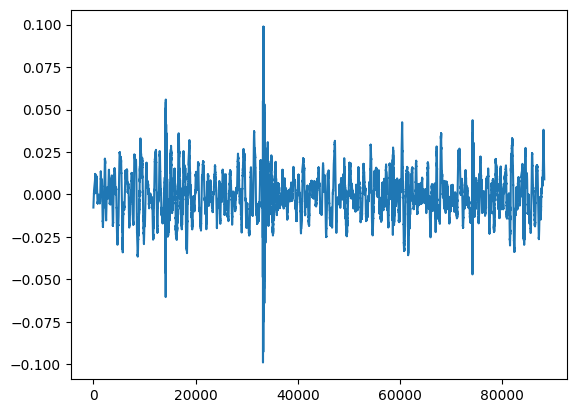

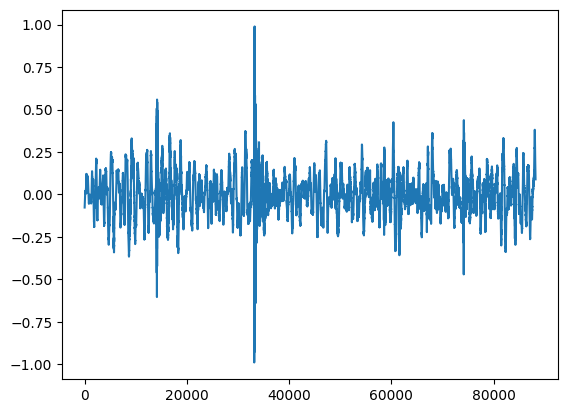

Statistics 1:  tensor([[5.7861e+00, 4.9605e-01, 1.1846e-02, 4.3386e-03],
        [4.2205e+00, 3.5280e-01, 1.0863e-02, 4.4789e-03],
        [1.3318e+00, 4.3578e-01, 1.7686e-02, 1.1955e-02],
        [1.2171e+00, 7.1129e-01, 3.7871e-02, 3.8520e-02],
        [6.3694e-01, 2.8602e+00, 1.2936e-01, 2.2700e-01],
        [7.3530e-01, 4.4661e+00, 1.4902e-01, 3.0176e-01],
        [4.6979e-01, 1.5173e+01, 1.7216e-01, 3.8800e-01],
        [4.1041e-01, 1.6104e+01, 1.7304e-01, 3.8999e-01],
        [2.8735e-01, 1.9797e+01, 1.6733e-01, 3.5053e-01],
        [3.0204e-01, 9.3067e+00, 1.6611e-01, 3.7365e-01],
        [2.1967e-01, 1.1615e+01, 1.4589e-01, 2.9188e-01],
        [5.5713e-01, 1.8112e+00, 1.1655e-01, 2.4073e-01],
        [2.8397e-01, 5.9515e+00, 1.5629e-01, 3.4027e-01],
        [1.1085e+00, 8.2527e-01, 5.0152e-02, 7.0502e-02],
        [4.4002e-01, 2.6195e+00, 1.6294e-01, 4.2934e-01],
        [3.4830e+00, 5.8795e-01, 1.1133e-02, 4.1608e-03]])
Statistics 2:  tensor([0.9547, 0.1075, 0.6616, 0.0068, 0

In [8]:
import librosa as lr

audio, _ = librosa.load("sounds/fire_long.wav", sr=44100)

from IPython.display import Audio

segment_1 = 0.1 * audio[2*44100:4*44100]
segment_2 = audio[2*44100:4*44100]

plt.plot(segment_1)
plt.show()
display(Audio(segment_1, rate=44100))

plt.plot(segment_2)
plt.show()
display(Audio(segment_2, rate=44100))

segment_1 = torch.tensor(segment_1)
segment_2 = torch.tensor(segment_2)

loss = statistics_loss(segment_1, segment_2)

print("loss: ",loss)

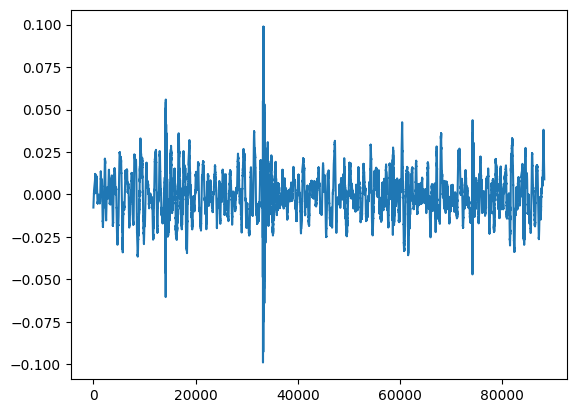

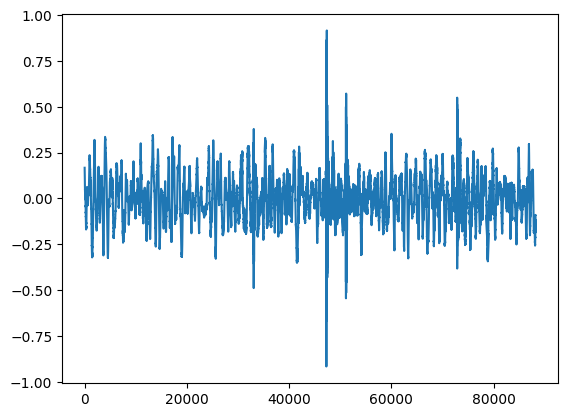

Statistics 1:  tensor([[5.7861e+00, 4.9605e-01, 1.1846e-02, 4.3386e-03],
        [4.2205e+00, 3.5280e-01, 1.0863e-02, 4.4789e-03],
        [1.3318e+00, 4.3578e-01, 1.7686e-02, 1.1955e-02],
        [1.2171e+00, 7.1129e-01, 3.7871e-02, 3.8520e-02],
        [6.3694e-01, 2.8602e+00, 1.2936e-01, 2.2700e-01],
        [7.3530e-01, 4.4661e+00, 1.4902e-01, 3.0176e-01],
        [4.6979e-01, 1.5173e+01, 1.7216e-01, 3.8800e-01],
        [4.1041e-01, 1.6104e+01, 1.7304e-01, 3.8999e-01],
        [2.8735e-01, 1.9797e+01, 1.6733e-01, 3.5053e-01],
        [3.0204e-01, 9.3067e+00, 1.6611e-01, 3.7365e-01],
        [2.1967e-01, 1.1615e+01, 1.4589e-01, 2.9188e-01],
        [5.5713e-01, 1.8112e+00, 1.1655e-01, 2.4073e-01],
        [2.8397e-01, 5.9515e+00, 1.5629e-01, 3.4027e-01],
        [1.1085e+00, 8.2527e-01, 5.0152e-02, 7.0502e-02],
        [4.4002e-01, 2.6195e+00, 1.6294e-01, 4.2934e-01],
        [3.4830e+00, 5.8795e-01, 1.1133e-02, 4.1608e-03]])
Statistics 2:  tensor([0.9547, 0.1075, 0.6616, 0.0068, 0

In [9]:
import librosa as lr

audio, _ = librosa.load("sounds/fire_long.wav", sr=44100)

from IPython.display import Audio

segment_1 = 0.1 *  audio[2*44100:4*44100]
segment_2 = audio[5*44100:7*44100]

plt.plot(segment_1)
plt.show()
display(Audio(segment_1, rate=44100))

plt.plot(segment_2)
plt.show()
display(Audio(segment_2, rate=44100))

segment_1 = torch.tensor(segment_1)
segment_2 = torch.tensor(segment_2)

loss = statistics_loss(segment_1, segment_2)

print("loss: ",loss)

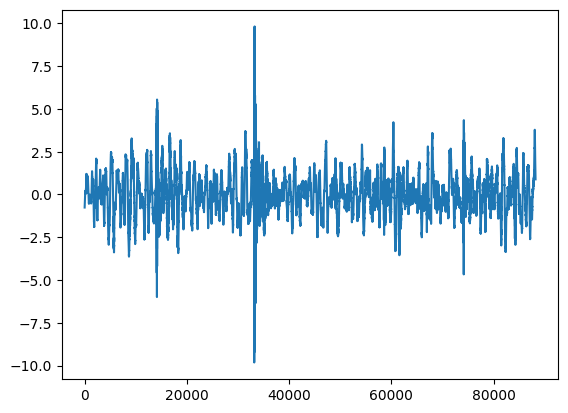

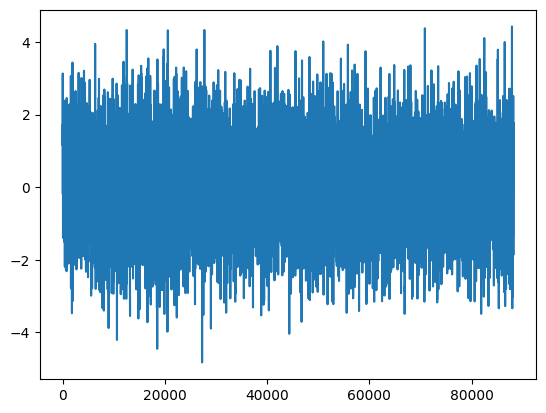

Statistics 1:  tensor([[5.7485e+02, 4.9605e-01, 1.1846e-02, 4.3386e-03],
        [4.1930e+02, 3.5280e-01, 1.0863e-02, 4.4789e-03],
        [1.3232e+02, 4.3578e-01, 1.7686e-02, 1.1955e-02],
        [1.2092e+02, 7.1129e-01, 3.7871e-02, 3.8520e-02],
        [6.3279e+01, 2.8602e+00, 1.2936e-01, 2.2700e-01],
        [7.3052e+01, 4.4661e+00, 1.4902e-01, 3.0176e-01],
        [4.6674e+01, 1.5173e+01, 1.7216e-01, 3.8800e-01],
        [4.0774e+01, 1.6104e+01, 1.7304e-01, 3.8999e-01],
        [2.8548e+01, 1.9797e+01, 1.6733e-01, 3.5053e-01],
        [3.0008e+01, 9.3067e+00, 1.6611e-01, 3.7365e-01],
        [2.1825e+01, 1.1615e+01, 1.4589e-01, 2.9188e-01],
        [5.5351e+01, 1.8112e+00, 1.1655e-01, 2.4073e-01],
        [2.8212e+01, 5.9515e+00, 1.5629e-01, 3.4027e-01],
        [1.1013e+02, 8.2527e-01, 5.0152e-02, 7.0502e-02],
        [4.3716e+01, 2.6195e+00, 1.6294e-01, 4.2934e-01],
        [3.4604e+02, 5.8795e-01, 1.1133e-02, 4.1608e-03]])
Statistics 2:  tensor([0.9547, 0.1075, 0.6616, 0.0068, 0

In [10]:
audio_fire,  _ = librosa.load("sounds/fire_long.wav", sr=44100)
audio_water, _ = librosa.load("sounds/ocean_and_gulls.wav", sr=44100)

audio_fire = (audio_fire - np.mean(audio_fire)) / np.std(audio_fire)
audio_water = (audio_water - np.mean(audio_water)) / np.std(audio_water)

from IPython.display import Audio

segment_1 = audio_fire[2*44100:4*44100]
segment_2 = audio_water[5*44100:7*44100]

plt.plot(segment_1)
plt.show()
display(Audio(segment_1, rate=44100))

plt.plot(segment_2)
plt.show()
display(Audio(segment_2, rate=44100))

segment_1 = torch.tensor(segment_1)
segment_2 = torch.tensor(segment_2)

loss = statistics_loss(segment_1, segment_2)
print("loss_final: ",loss)